In [1]:
import pickle
from src.utils import load_checkpoint

df = load_checkpoint('src/extract/dataframe_checkpoint_20.pickle')

Loading checkpoint from src/extract/dataframe_checkpoint_20.pickle
Loaded 19262 rows and 3 columns.


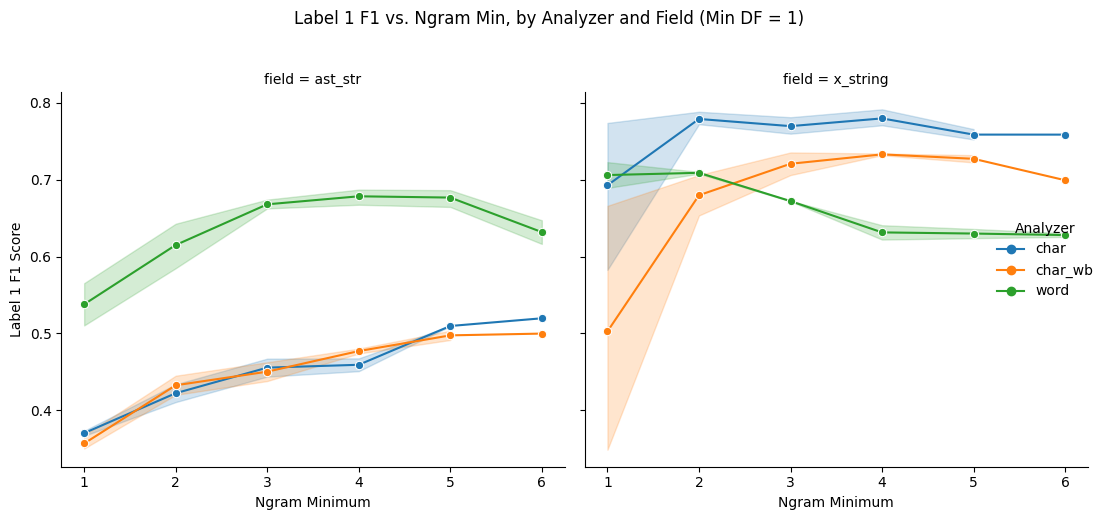

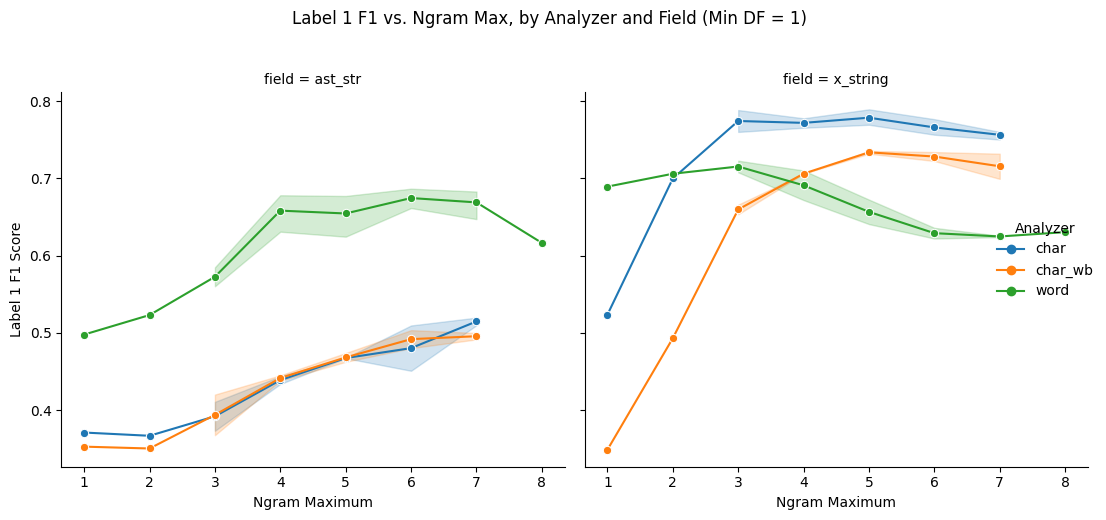

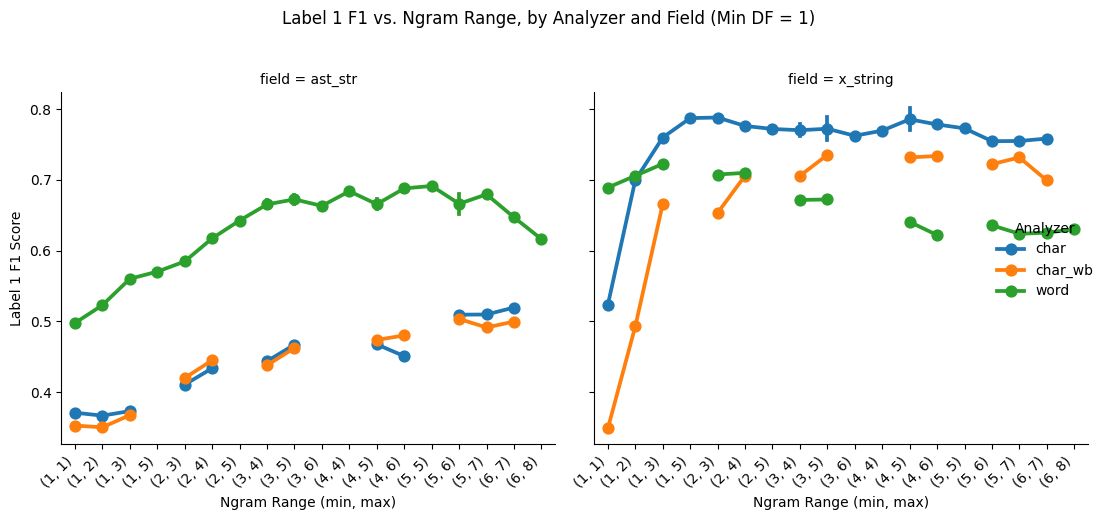

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

g = sns.relplot(data=results_df_combined, x='ngram_min', y='label_1_f1',
                hue='analyzer', col='field', kind='line', marker='o')
g.fig.suptitle('Label 1 F1 vs. Ngram Min, by Analyzer and Field (Min DF = 1)', y=1.03) # Adjust title position
g.set_axis_labels("Ngram Minimum", "Label 1 F1 Score")
g.legend.set_title("Analyzer")
plt.tight_layout()
plt.show()


g = sns.relplot(data=results_df_combined, x='ngram_max', y='label_1_f1',
                hue='analyzer', col='field', kind='line', marker='o')
g.fig.suptitle('Label 1 F1 vs. Ngram Max, by Analyzer and Field (Min DF = 1)', y=1.03) # Adjust title position
g.set_axis_labels("Ngram Maximum", "Label 1 F1 Score")
g.legend.set_title("Analyzer")
plt.tight_layout()
plt.show()


results_df_combined['ngram_range_str'] = results_df_combined.apply(lambda row: f"({row['ngram_min']}, {row['ngram_max']})", axis=1)
results_df_sorted_ngram = results_df_combined.sort_values(by=['ngram_min', 'ngram_max'])

g = sns.catplot(data=results_df_sorted_ngram, x='ngram_range_str', y='label_1_f1',
                hue='analyzer', col='field', kind='point', sharex=False) # kind='point' is good for categorical x
g.fig.suptitle('Label 1 F1 vs. Ngram Range, by Analyzer and Field (Min DF = 1)', y=1.03)
g.set_axis_labels("Ngram Range (min, max)", "Label 1 F1 Score")
g.set_xticklabels(rotation=45, ha="right") # Rotate labels if they overlap
g.legend.set_title("Analyzer")
plt.tight_layout()
plt.show()

In [ ]:
import pickle
from typing import Dict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import parallel_coordinates
from sklearn.metrics import auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix


y = df['target']

with open('src/features/matrices/matrix_man-str.pickle', 'rb') as f:
    man_str_matrix = pickle.load(f)

class CombinedFeatures(BaseEstimator, TransformerMixin):
    """Combine TF-IDF of x_string with manual features by weight."""
    def __init__(self, analyzer: str = 'char', ngram_range: tuple = (4, 5), min_df: int = 1, weight: float = 0.1) -> None:
        self.analyzer = analyzer
        self.ngram_range = ngram_range
        self.min_df = min_df
        self.weight = weight

    def fit(self, X: pd.DataFrame, y=None):
        text = X['x_string']
        self.vectorizer = TfidfVectorizer(
            analyzer=self.analyzer,
            ngram_range=self.ngram_range,
            min_df=self.min_df
        )
        self.vectorizer.fit(text)
        return self

    def transform(self, X: pd.DataFrame):
        text = X['x_string']
        tfidf_part = self.vectorizer.transform(text).multiply(1.0 - self.weight)
        idx = X.index.to_numpy()
        man_part = man_str_matrix[idx, :].multiply(self.weight)
        return hstack([tfidf_part, man_part], format="csr")

# load pickle
results_df_combined:Dict
with open('skopt_results.pickle', 'wb') as f:
    results_df_combined = pickle.load(f)

# Assuming only the first 3 models worked, as per your instruction
processed_models = ['svm', 'logistic', 'decision_tree']
available_models_in_pickle = list(results_df_combined.keys())

print(f"Models found in pickle: {available_models_in_pickle}")
print(f"Processing models: {processed_models}\n")


def plot_parallel_coordinates_custom(cv_results_df, model_name_str):
    param_cols = [col for col in cv_results_df.columns if col.startswith('param_')]
    if not param_cols:
        print(f"No 'param_' columns in cv_results for {model_name_str}.")
        return

    plot_df = cv_results_df[param_cols + ['mean_test_score']].copy()
    plot_df.rename(columns={'mean_test_score': 'F1_Score'}, inplace=True)

    # Handle categorical data by factorizing for plotting
    # Store mappings for tick labels
    tick_mappings = {}
    for col in param_cols:
        if plot_df[col].dtype == 'object' or pd.api.types.is_categorical_dtype(plot_df[col]):
            original_values = plot_df[col].astype('category')
            plot_df[col] = original_values.cat.codes
            tick_mappings[col] = dict(enumerate(original_values.cat.categories))

    plt.figure(figsize=(max(10, len(param_cols) * 1.5), 6)) # Adjust width
    pc = parallel_coordinates(
        plot_df,
        class_column='F1_Score', # Color lines by F1_Score
        cols=param_cols + ['F1_Score'], # Ensure F1_Score is last for y-axis on right
        colormap='viridis',
        alpha=0.5
    )

    # Customize ticks for categorical features
    ax = plt.gca()
    current_xticks = ax.get_xticks() # These are indices 0, 1, 2...
    new_xticklabels = []

    for i, col_name in enumerate(param_cols): # Iterate through param_cols used in plot
        clean_col_name = col_name.replace("param_", "").replace("classifier__", "").replace("combined__", "")
        new_xticklabels.append(clean_col_name)
        if col_name in tick_mappings:
            # This is more complex for parallel_coordinates' y-axes per feature.
            # We'll just ensure the x-axis label is correct.
            # For actual tick values on each axis, it's often better to use libraries
            # like Plotly or inspect individual axes if matplotlib's default isn't clear.
            pass
    # Add F1_Score to x-tick labels if it's part of the axes
    if 'F1_Score' in plot_df.columns and len(current_xticks) == len(param_cols) + 1:
         new_xticklabels.append('F1_Score')

    if len(current_xticks) == len(new_xticklabels):
        ax.set_xticklabels(new_xticklabels)
    else: # Fallback if lengths don't match (e.g. F1_Score not treated as an axis by pc)
        ax.set_xticklabels([col.replace("param_", "").replace("classifier__", "").replace("combined__", "") for col in param_cols])


    plt.title(f'Parallel Coordinates for {model_name_str} Hyperparameters')
    plt.xticks(rotation=30, ha='right')
    plt.tight_layout()
    plt.show()

print("\n--- Parallel Coordinates Plots ---")
for model_name in processed_models:
    if model_name in results_df_combined:
        print(f"Generating Parallel Coordinates for: {model_name}")
        cv_df = results_df_combined[model_name]['cv_results']
        plot_parallel_coordinates_custom(cv_df, model_name)
    else:
        print(f"Skipping {model_name}: Not found in pickled results or not in processed list.")


best_overall_model_name = None
highest_f1_score = -1.0
best_model_entry = None

for model_name in processed_models:
    if model_name in results_df_combined:
        current_f1 = results_df_combined[model_name].get('best_f1_score', -1.0)
        if current_f1 > highest_f1_score:
            highest_f1_score = current_f1
            best_overall_model_name = model_name
            best_model_entry = results_df_combined[model_name]

print("\n--- Best Overall Model Analysis ---")
if best_overall_model_name and best_model_entry:
    print(f"Best overall model (from processed list): {best_overall_model_name} with F1 = {highest_f1_score:.4f}")

    # Plot ROC AUC Curve (using stored CV predictions)
    if 'fpr_cv' in best_model_entry and 'tpr_cv' in best_model_entry and 'roc_auc_cv' in best_model_entry:
        fpr = best_model_entry['fpr_cv']
        tpr = best_model_entry['tpr_cv']
        roc_auc = best_model_entry['roc_auc_cv']

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (CV area = {roc_auc:.3f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {best_overall_model_name} (Cross-Validated Scores)')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()
    else:
        print(f"ROC curve data (fpr_cv, tpr_cv, roc_auc_cv) not found for {best_overall_model_name}.")

    # Plot Confusion Matrix (requires df, y, and working best_estimator)
    if df is not None and y is not None:
        best_estimator = best_model_entry.get('best_estimator')
        if best_estimator:
            try:
                # Ensure df[['x_string']] is in the correct format for your CombinedFeatures
                # If your CombinedFeatures expects a 1D array or list of strings:
                # X_for_predict = df['x_string']
                # If it expects a DataFrame with a specific column name:
                X_for_predict = df[['x_string']]


                y_pred = best_estimator.predict(X_for_predict)
                cm = confusion_matrix(y, y_pred, labels=best_estimator.classes_)
                
                disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_estimator.classes_)
                fig, ax = plt.subplots(figsize=(7, 7))
                disp.plot(ax=ax, cmap=plt.cm.Blues)
                ax.set_title(f'Confusion Matrix - {best_overall_model_name}')
                plt.show()
            except Exception as e:
                print(f"Could not generate confusion matrix for {best_overall_model_name}: {e}")
                print("Ensure 'CombinedFeatures' is correctly defined and 'df'/'y' are appropriate.")
        else:
            print(f"Best estimator not found in results for {best_overall_model_name}.")
    else:
        print("Skipping confusion matrix: `df` or `y` not provided.")
else:
    print("No best overall model found among the processed models.")

print("\nVisualization script finished.")

EOFError: Ran out of input